In [1]:
import symforce
symforce.set_epsilon_to_symbol()

In [2]:
import numpy as np
from symforce.values import Values

import rosbag2_py
from rclpy.serialization import deserialize_message

In [4]:
bag_path = "../bags/dataset_drive_square_no_vid"
# Copied the following from https://qiita.com/nonanonno/items/8f7bce03953709fd5af9
storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")

sr = rosbag2_py.SequentialReader()
sr.open(storage_options, converter_options)
sr.set_filter(rosbag2_py.StorageFilter(topics=["/odom", "/detections", "/camera/camera_info"]))

[INFO] [1699507137.323134070] [rosbag2_storage]: Opened database '../bags/dataset_drive_square_no_vid/rosbag2_2023_10_25-11_14_04_0.db3' for READ_ONLY.


In [5]:
# Create a dictionary of each topic's message type
# This will be used for deserializing the messages.
import importlib
def get_type_from_str(type_str: str):
    # dynamic load message package
    pkg = importlib.import_module(".".join(type_str.split("/")[:-1]))
    return eval(f"pkg.{type_str.split('/')[-1]}")

msg_type_table = {}
for topic in sr.get_all_topics_and_types():
    msg_type_table[topic.name] = get_type_from_str(topic.type)

In [6]:
# Now we extract messages from the entire bag
sr.seek(0)
msgs = []
while sr.has_next():
    msgs.append(sr.read_next())

msgs_no_cam = [msg for msg in msgs if not (msg[0] == "/camera/camera_info")]

[INFO] [1699507139.693725995] [rosbag2_storage]: Opened database '../bags/dataset_drive_square_no_vid/rosbag2_2023_10_25-11_14_04_0.db3' for READ_ONLY.


In [7]:
# Extract detections and odometry messages
f_deserialize_msg = lambda msg: deserialize_message(msg[1], msg_type_table[msg[0]])
def get_first_msg_of_topic(topic):
    return next(deserialize_message(msg[1], msg_type_table[msg[0]]) for msg in msgs if msg[0] == topic)

example_odom_data = get_first_msg_of_topic("/odom")
example_detections_data = get_first_msg_of_topic("/detections")
example_camera_info_data = get_first_msg_of_topic("/camera/camera_info")

print(example_odom_data)
print("---")
print(example_detections_data)
print("---")
print(example_camera_info_data)

nav_msgs.msg.Odometry(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1697911413, nanosec=507019835), frame_id='odom'), child_frame_id='base_footprint', pose=geometry_msgs.msg.PoseWithCovariance(pose=geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.002499930899425671, y=2.0161891289617244e-06, z=0.0), orientation=geometry_msgs.msg.Quaternion(x=0.0, y=0.0, z=-0.010080474430627446, w=0.9999491907268356)), covariance=array([1.e-01, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+05, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+05, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 1.e+05])), twist=geometry_msgs.msg.TwistWithCovariance(twist=geometry_msgs.msg.Twist(linear=geometry_msgs.msg.Vector3(x=0.0, y=0.0, z=0.0), angular=geometry_msgs.msg.Vector3(x=0.0, y=0.0, z=0.0)), covariance=array([0., 0., 0., 0., 0., 0., 

In [8]:
import symforce.symbolic as sf
# Get the example messages into np form to play around with them
example_corners = np.array([
    np.array([corner.x, corner.y])
    for corner in example_detections_data.detections[0].corners
])

camera_K = np.reshape(example_camera_info_data.k, (3, 3))
focal_length = [camera_K[0, 0], camera_K[1, 1]]
principal_point = [camera_K[0, 2], camera_K[1, 2]]
camera_cal = sf.LinearCameraCal(focal_length=focal_length, principal_point = principal_point)

In [249]:
## Phase 1: Integrate odometry using Symforce?
# Define the odometry residual function?
from symforce.codegen.geo_factors_codegen import prior_factor, between_factor

def residual_between(pose_1: sf.Pose3, pose_2: sf.Pose3, rdelta_measured: sf.Pose3, epsilon: sf.Scalar):
    # Compute the expected body-frame displacement
    # pose_1 * rdelta = pose_2
    rdelta_expected = pose_1.inverse() * pose_2

    # The "error": rdelta_expected ⊟ rdelta_measured
    error = rdelta_measured.local_coordinates(rdelta_expected, epsilon)
    return error

R_robot_cam = sf.Rot3.from_yaw_pitch_roll(-np.pi/2, 0, -np.pi/2)
t_robot_cam = sf.Vector3([-0.1016, 0, 0.0889])
g_robot_cam = sf.Pose3(R_robot_cam, t_robot_cam)
def get_tag_corner_residual(i_corner: np.int_):
    ## Get the position of the tags in the camera frame
    # Define the displacements from the tag center to each tag corner
    R = sf.Rot3.identity()
    w = 0.203
    # Corner order: start in bottom left (-x, -y) and go ccw
    g_tag_c1 = sf.Pose3(R, sf.Vector3([-w/2, w/2, 0]))
    g_tag_c2 = sf.Pose3(R, sf.Vector3([w/2, w/2, 0]))
    g_tag_c3 = sf.Pose3(R, sf.Vector3([w/2, -w/2, 0]))
    g_tag_c4 = sf.Pose3(R, sf.Vector3([-w/2, -w/2, 0]))
    g_tag_corners = [g_tag_c1, g_tag_c2, g_tag_c3, g_tag_c4]
    g_tag_ci = g_tag_corners[i_corner]

    def residual_tag_obs(robot_pose: sf.Pose3, tag_pose: sf.Pose3, corners_px_measured: sf.M12, epsilon: sf.Scalar):
        # Measure the error between the expected pixel coordinates of the tag corners
        # versus the actual measured ones.
        camera_pose = robot_pose * g_robot_cam

        # Compute the expected tag corner positions in the camera frame
        # based on the hypothesized camera and tag poses.
        g_cam_tag = camera_pose.inverse() * tag_pose
        g_cam_corner = g_cam_tag * g_tag_ci
    
        # Project the tag corner positions into the camera frame using the camera model
        corners_px_expected = camera_cal.pixel_from_camera_point(g_cam_corner.t, epsilon)[0]
    
        return corners_px_measured.T - corners_px_expected
    return residual_tag_obs
    

In [250]:
from symforce.opt.factor import Factor
from symforce.values import Values

start_factor = 300
n_factors = 20
tag_ids = [0, 1, 2, 3, 4, 5]

# Supporting functions
def pose3_msg_to_sf(msg):
    q_xyz = [msg.orientation.x, msg.orientation.y, msg.orientation.z]
    w = msg.orientation.w
    quat = sf.Quaternion(xyz=sf.Vector3(q_xyz), w=w)
    R = sf.Rot3(quat)

    posn = [msg.position.x, msg.position.y, msg.position.z]
    t = sf.Vector3(posn)
    return sf.Pose3(R, t)

## Initialize storage vars
factors = []
# Store odometry sensor data
i_pose = 0
odoms = []
poses = [sf.Pose3.identity()]
last_pose = sf.Pose3.identity()
# Store tag detections
n_detections = [0 for id in tag_ids]
detections = [[] for id in tag_ids]
last_odom_time = 0
for i in range(start_factor, start_factor + n_factors):
    topic, bdata, time = msgs_no_cam[i]
    data = f_deserialize_msg(msgs_no_cam[i])

    if topic == "/odom":
        ## Add a between-factor to the factor graph
        factors.append(Factor(
            residual=residual_between,
            keys=[f"poses[{i_pose}]", f"poses[{i_pose+1}]", f"odoms[{i_pose}]", "epsilon"]
        ))

        ## Record the sensor data into the list of displacements
        pose = pose3_msg_to_sf(data.pose.pose)
        if i_pose == 0:
            # If first displacement measurement, simply record 0
            odoms.append(sf.Pose3.identity())
            poses.append(sf.Pose3.identity())
        else:
            # Otherwise, record the displacement from the last pose
            # last_pose * delta = pose
            # => delta = inv(last_pose) * pose
            delta = last_pose.inverse() * pose
            odoms.append(delta)
            poses.append(poses[-1] * delta)
        
        last_pose = pose
        i_pose = i_pose + 1
        last_odom_time = time
        
    elif topic == "/detections" and (time - last_odom_time) * 1e-9 < 0.02:
        for detection in data.detections:
            tag_id = detection.id
            
            corners_i = []
            for i, corner in enumerate(detection.corners):
                factors.append(Factor(
                    residual=get_tag_corner_residual(i),
                    keys=[
                        f"poses[{i_pose}]",
                        f"tag_poses[{tag_id}]",
                        f"detections[{tag_id}][{n_detections[tag_id]}][{i}]",
                        "epsilon"
                    ]
                ))

                corners_i.append(sf.M12([corner.x, corner.y]))
            detections[tag_id].append(corners_i)
            # Count a new detection for this tag
            n_detections[tag_id] += 1

n_poses = i_pose + 1
initial_poses = poses
#initial_tag_poses = [[sf.Pose3.identity()] * n_detections[id] for id in tag_ids]
initial_tag_poses = [sf.Pose3.identity()] * len(tag_ids)

for i, detection_list in enumerate(detections):
    if n_detections[i] == 0:
        detections[i] = [[0]]
        initial_tag_poses[i] = sf.Pose3.identity()

initial_values = Values(
    poses = initial_poses,
    odoms = odoms,
    detections = detections,
    tag_poses = initial_tag_poses,
    epsilon = sf.numeric_epsilon
)

In [251]:
from symforce.opt.optimizer import Optimizer

pose_keys = [f"poses[{i}]" for i in range(n_poses)]
tag_keys = [f"tag_poses[{tag_id}]" for tag_id in tag_ids if n_detections[tag_id] != 0]

optimizer = Optimizer(
    factors=factors,
    optimized_keys=pose_keys+tag_keys,
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
)
result = optimizer.optimize(initial_values)

[2023-11-09 22:38:26.253] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 8.769e+11/0.000e+00/1.018e+33, rel reduction: -1.16063e+21
[2023-11-09 22:38:26.256] [info] LM<sym::Optimize> [iter    1] lambda: 4.000e+00, error prev/linear/new: 8.769e+11/0.000e+00/1.030e+33, rel reduction: -1.17432e+21
[2023-11-09 22:38:26.258] [info] LM<sym::Optimize> [iter    2] lambda: 1.600e+01, error prev/linear/new: 8.769e+11/0.000e+00/1.037e+33, rel reduction: -1.18212e+21
[2023-11-09 22:38:26.260] [info] LM<sym::Optimize> [iter    3] lambda: 6.400e+01, error prev/linear/new: 8.769e+11/0.000e+00/1.039e+33, rel reduction: -1.18476e+21
[2023-11-09 22:38:26.261] [info] LM<sym::Optimize> [iter    4] lambda: 2.560e+02, error prev/linear/new: 8.769e+11/0.000e+00/1.040e+33, rel reduction: -1.18544e+21
[2023-11-09 22:38:26.263] [info] LM<sym::Optimize> [iter    5] lambda: 1.024e+03, error prev/linear/new: 8.769e+11/0.000e+00/1.040e+33, rel reduction: -1.18602e+21
[2023-11-09 22:3

In [252]:
import plotly.graph_objects as go

robot_poses_initial = initial_poses
robot_t_initial = np.array([pose.t for pose in robot_poses_initial], dtype=np.float32)

robot_poses_optimized = result.optimized_values["poses"]
robot_t_optimized = np.array([pose.t for pose in robot_poses_optimized], dtype=np.float32)

tag_poses = result.optimized_values["tag_poses"]
tag_t = np.array([pose.t for pose in tag_poses])

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x = robot_t_initial[:, 0],
    y = robot_t_initial[:, 1],
    z = robot_t_initial[:, 2],
    name="initial"
))

fig.add_trace(go.Scatter3d(
    x = robot_t_optimized[:, 0],
    y = robot_t_optimized[:, 1],
    z = robot_t_optimized[:, 2],
     name="optimized"
))

fig.add_trace(go.Scatter3d(
    x = tag_t[:, 0],
    y = tag_t[:, 1],
    z = tag_t[:, 2],
    mode="markers",
    name="tags",
    text=[f"tag {i}" for i in range(len(tag_ids))],
    marker={
        "color": "black"
    }
))

fig.update_layout(width=800, height=800, scene_aspectmode="data", scene=dict(
    zaxis=dict(range=[-0.25, 0.25])
))

In [253]:
g = symforce.opt.factor.visualize_factors(factors)
g.render("test")

# TODOS:
# 1. Initialize the pose estimates using integrated odometry measurements
# 2. Diagram and think through how to handle tag detections coming 
#    in at a higher rate than the odometry

'test.pdf'

In [337]:
# To debug this, we should first verify that our residual functions are correct
# We already know that the odometry residual is correct, because even if we do not pre-integrate
# the solver is still able to recover the integrated odometry trajectory

# However, the major question is whether our tag residual function is correct. To test that,
# we can compute the residual function's value for a loose estimate of one of the starting tags' poses

# First, call the residual function on a naive guess for the tag pose
detection_tag3 = detections[3]

In [338]:
import cv2 as cv

w = 0.203
objps = np.array([
    [-w/2, w/2, 0],
    [w/2, w/2, 0],
    [w/2, -w/2, 0],
    [-w/2, -w/2, 0],
])
imageps = np.array(detections[3][0], dtype=np.float64)

pnpsoln = cv.solvePnP(objps, imageps, camera_K, np.array([]), flags=cv.SOLVEPNP_SQPNP)

In [386]:
# Now let's try again on the new pose based on OpenCV:
np.linalg.norm(pnpsoln[1])
proposed_tag3_R = sf.Rot3.from_angle_axis(theta, sf.Vector3(pnpsoln[1]) / theta)
proposed_tag3_t = sf.Vector3(pnpsoln[2])
proposed_tag3_cam_to_tag = sf.Pose3(proposed_tag3_R, proposed_tag3_t)
proposed_tag3_pose = g_robot_cam * proposed_tag3_cam_to_tag

for detection in detection_tag2:
    for i, corner in enumerate(detection):
        print(f"Corner: {corner}")
        f_residual_corner = get_tag_corner_residual(i)
        res = f_residual_corner(sf.Pose3.identity(), proposed_tag3_pose, corner, 1e-6)
        print(f"Residual: {res}")

Corner: [165.3623046875, 132.419677734375]

Residual: [1.31650607149743]
[172.048449333743]

Corner: [78.6307525634766, 132.512603759766]

Residual: [172.507321632748]
[0.146446905057985]

Corner: [80.6741485595703, 218.533187866211]

Residual: [-1.88660464108276]
[-168.847325682969]

Corner: [167.004577636719, 218.265197753906]

Residual: [-169.709969187]
[0.120679666878829]



In [389]:
t_tag_corners = np.array([
    [-w/2, w/2, 0],
    [w/2, w/2, 0],
    [w/2, -w/2, 0],
    [-w/2, -w/2, 0],
])

def tag_residual(g_robot_pose, g_tag_pose, detection):
    res = sf.Matrix11()
    
    R_i = sf.Rot3.identity()
    # g_cam_tag = g_cam_world * g_world_tag
    #           = g_world_cam^-1 * g_world_tag
    #           = (g_world_robot * g_robot_cam)^-1 * g_world_tag
    g_cam_tag = (g_robot_pose * g_robot_cam).inverse() * g_tag_pose

    # Now use the tag pose to derive the associated corner positions
    g_world_corners = [g_cam_tag * sf.Pose3(R_i, sf.Vector3(t_i)) for t_i in t_tag_corners]
    t_world_corners = np.array([g_tag.t.to_numpy().squeeze() for g_tag in g_world_corners])

    # Use corner positions to find expected corner pixels, and compute reprojection error
    for i, corner in enumerate(detection):
        t_corner_i = t_world_corners[i]
        px_corner_i_est = camera_cal.pixel_from_camera_point(t_corner_i, 1e-6)[0]
        print(t_corner_i)
        res = res.col_join(px_corner_i_est - sf.Matrix12(detection[i]).T)

    return res[1:]

f = tag_residual(sf.Pose3.identity(), proposed_tag3_pose, detection_tag3[0])
print(f)

[-0.48934895 -0.61313451  1.15207061]
[-1.09515716 -0.20912061  1.15284231]
[-0.69137229  0.39648191  1.17046085]
[-0.08556407 -0.00753199  1.16968916]
[-1.31650607149743]
[-172.048449333743]
[-172.507321632748]
[-0.146446905057985]
[1.88660464108276]
[168.847325682969]
[169.709969187]
[-0.120679666878829]



In [390]:
def plot_poses(poses, text=[], axis_length=0.1, marker_size = 3, fig=go.Figure(), name="Poses"):
    # 3D matrix which stores the list of individual points to plot for each body-axis (x, y, z)
    # For each pose: store start point (at the center of pose), end point of the body-axis, and then insert 'None' to separate lines.
    # Note there will be a trailing 'None'.
    numels = 3*len(poses)
    body_points_xyz = np.zeros((3, 3, numels))

    posns = np.zeros((3, len(poses)))
    idx = 0
    for i, pose in enumerate(poses):
        # For each pose, compute where the x, y, and z axes will be pointing
        posn = pose.t.to_numpy().squeeze()
        R = pose.R.to_rotation_matrix().to_numpy()
        posns[:, i] = posn
        
        for i_axis, body_points_axis in enumerate(body_points_xyz):
            body_points_axis[:, idx] = posn
            body_points_axis[:, idx+1] = posn + R[:, i_axis] * axis_length
            body_points_axis[:, idx+2] = np.array([None, None, None])

        idx += 3
        
    axis_names = ["x", "y", "z"]
    axis_colors = ["#D81B60", "#00BF9F", "#278DE6"]
    for i, axis in enumerate(body_points_xyz):
        fig.add_trace(go.Scatter3d(
            x=axis[0, :],
            y=axis[1, :],
            z=axis[2, :],
            name=axis_names[i],
            mode="lines+markers",
            legendgroup="poses",
            showlegend=False,
            marker=dict(color=axis_colors[i], size=marker_size)
        ))
    
    fig.add_trace(go.Scatter3d(
        x=posns[0, :],
        y=posns[1, :],
        z=posns[2, :],
        mode="markers",
        name=name,
        legendgroup="poses",
        text=text,
        marker=dict(color="black", size=marker_size)
    ))

    fig.update_layout(width=800, height=800, scene_aspectmode="data")
    
    return fig

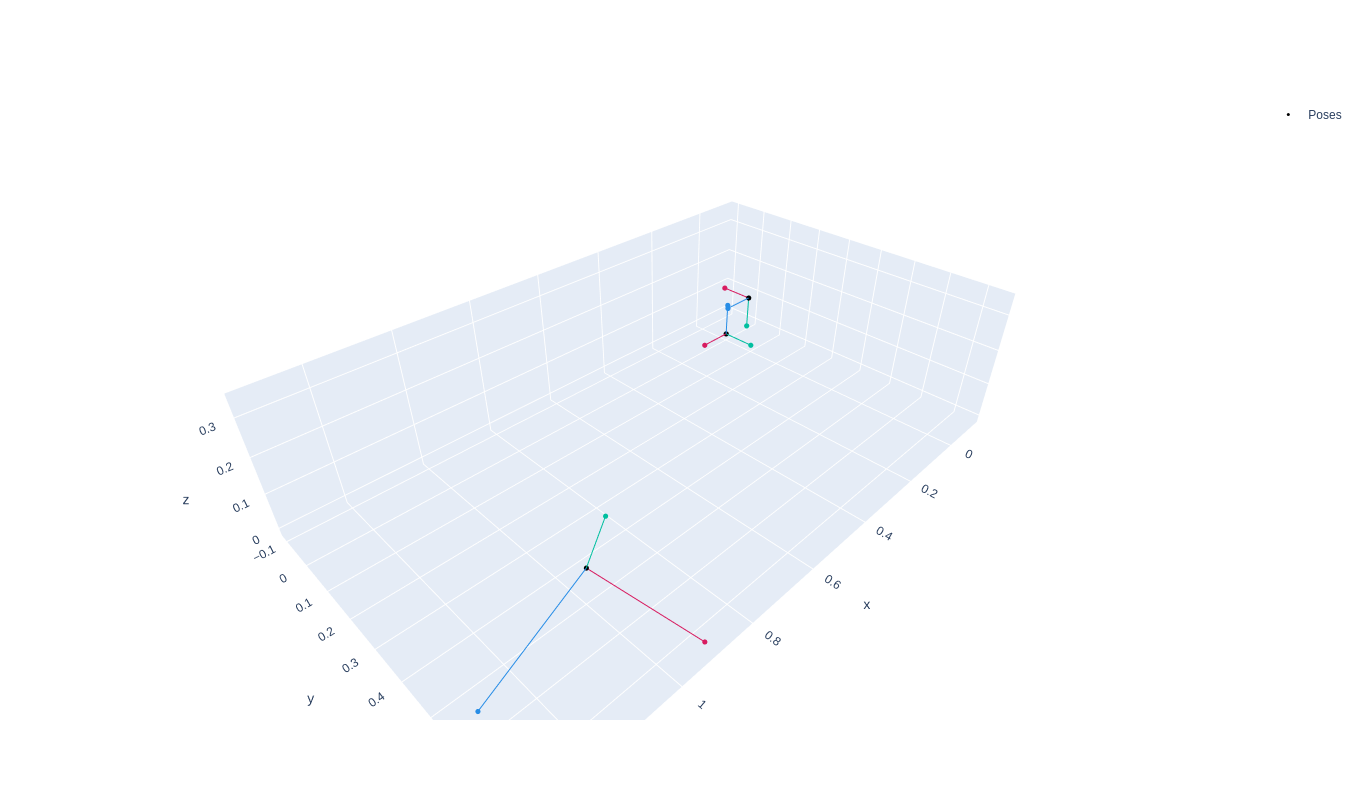

In [391]:
poses = [sf.Pose3.identity(), g_robot_cam, proposed_tag3_pose]
names = ["Robot", "Camera", "Tag"]
fig = go.Figure()
plot_poses(poses, names, fig=fig)